##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Using Gemini API to tag and caption images

You will use the Gemini model's vision capabilities and the embedding model to add tags and captions to images of pieces of clothing.

These descriptions can be used alongside embeddings to allow you to search for specific pieces of clothing using natural language, or other images.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Tag_and_caption_images.ipynb"><img src = "../images/colab_logo_32px.png"/>Run in Google Colab</a>
  </td>
</table>

## Setup

In [2]:
!pip install -U -q "google-generativeai>=0.7.2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.3/717.3 kB 6.5 MB/s eta 0:00:00


In [3]:
import time
import pathlib
from glob import glob

import numpy as np
import pandas as pd
import google.generativeai as genai
from IPython.display import Markdown, Image, display

## Configure your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [4]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=api_key)

## Downloading dataset
First, you need to download a dataset with images. It contains images of various clothing that you can use to test the model.

In [5]:
!wget https://storage.googleapis.com/generativeai-downloads/data/clothes-dataset.zip

--2024-06-18 17:00:35--  https://storage.googleapis.com/generativeai-downloads/data/clothes-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730831 (714K) [application/zip]
Saving to: ‘clothes-dataset.zip’

clothes-dataset.zip 100%[===================>] 713.70K  --.-KB/s    in 0.01s   

2024-06-18 17:00:35 (61.4 MB/s) - ‘clothes-dataset.zip’ saved [730831/730831]



Unzip the data in `clothes-dataset.zip` and place them in a folder in your Colab environment.

In [6]:
!unzip -o clothes-dataset.zip

Archive:  clothes-dataset.zip
  inflating: clothes-dataset/6.jpg   
  inflating: clothes-dataset/4.jpg   
  inflating: clothes-dataset/1.jpg   
  inflating: clothes-dataset/2.jpg   
  inflating: clothes-dataset/7.jpg   
  inflating: clothes-dataset/9.jpg   
  inflating: clothes-dataset/8.jpg   
  inflating: clothes-dataset/10.jpg  
  inflating: clothes-dataset/5.jpg   
  inflating: clothes-dataset/3.jpg   


In [7]:
images = glob("/content/clothes-dataset/*")
images.sort(reverse=True)

## Generating keywords
You can use the LLM to extract relevant keywords from the images.

Here is a helper function for calling Gemini API with images. Sleep is for ensuring that the quota is not exceeded. As of June 2024, the quota for the 1.5 Flash model is 15 requests per second for the free tier.

In [8]:
# a helper function for calling
def generate_text_using_image(prompt, image_path, sleep_time=4):
  start = time.perf_counter()
  model = genai.GenerativeModel('gemini-1.5-flash-latest', system_instruction=prompt)
  response = model.generate_content(
    contents=[Image(image_path)]
  )
  end = time.perf_counter()
  duration = end - start
  time.sleep(sleep_time - duration if duration < sleep_time else 0)
  return response.text

First, define the list of possible keywords.

In [9]:
keywords = np.concatenate((
    ["flannel", "shorts", "pants", "dress", "T-shirt", "shirt", "suit"],
    ["women", "men", "boys", "girls"],
    ["casual", "sport", "elegant"],
    ["fall", "winter", "spring", "summer"],
    ["red", "violet", "blue", "green", "yellow", "orange", "black", "white"],
    ["polyester", "cotton", "denim", "silk", "leather", "wool", "fur"]
)
)

Go ahead and define a prompt that will help define keywords that describe clothing. In the following prompt, few-shot prompting is used to prime the LLM with examples of how these keywords should be generated and which are valid.

In [10]:
keyword_prompt =f"""
You are an expert in clothing that specializes in tagging images of clothes, shoes and accessories.
Your job is to extract all relevant keywords from a photo that will help describe an item.
You are going to see an image, extract only the keywords for the clothing, try to provide as many keywords as possible.

Allowed keywords: {list(keywords)}

Extract tags only when it is obvious that it describes the main item in the image.
Return the keywords as a list of strings:
example1: ["blue", "shoes", "denim"]
example2: ["sport", "skirt", "cotton", "blue", "red"]
"""

In [11]:
def generate_keywords(image_path):
  return generate_text_using_image(keyword_prompt, image_path)

Generate keywords for each of the images.

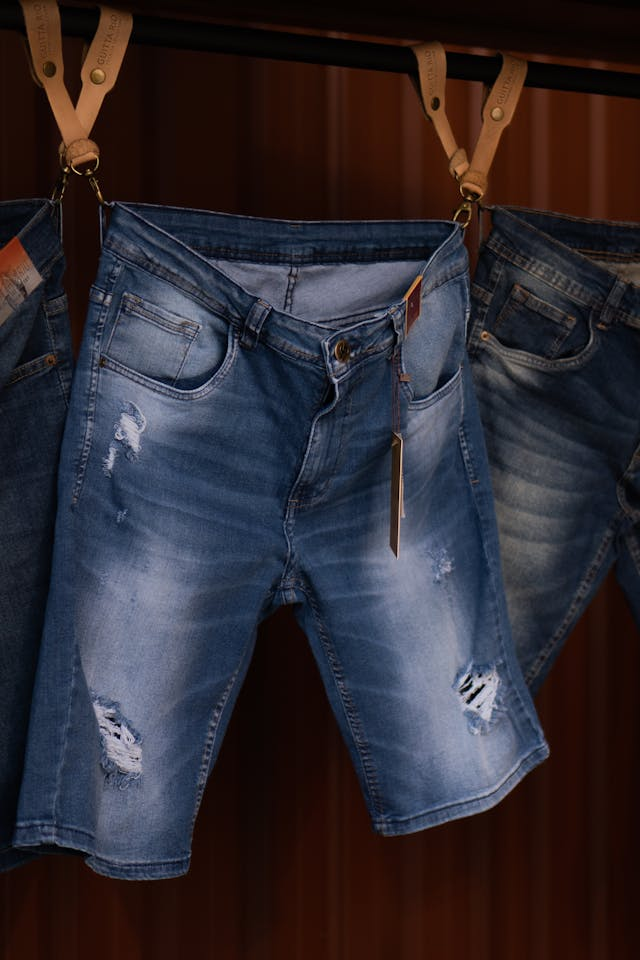

['denim', 'blue', 'shorts']


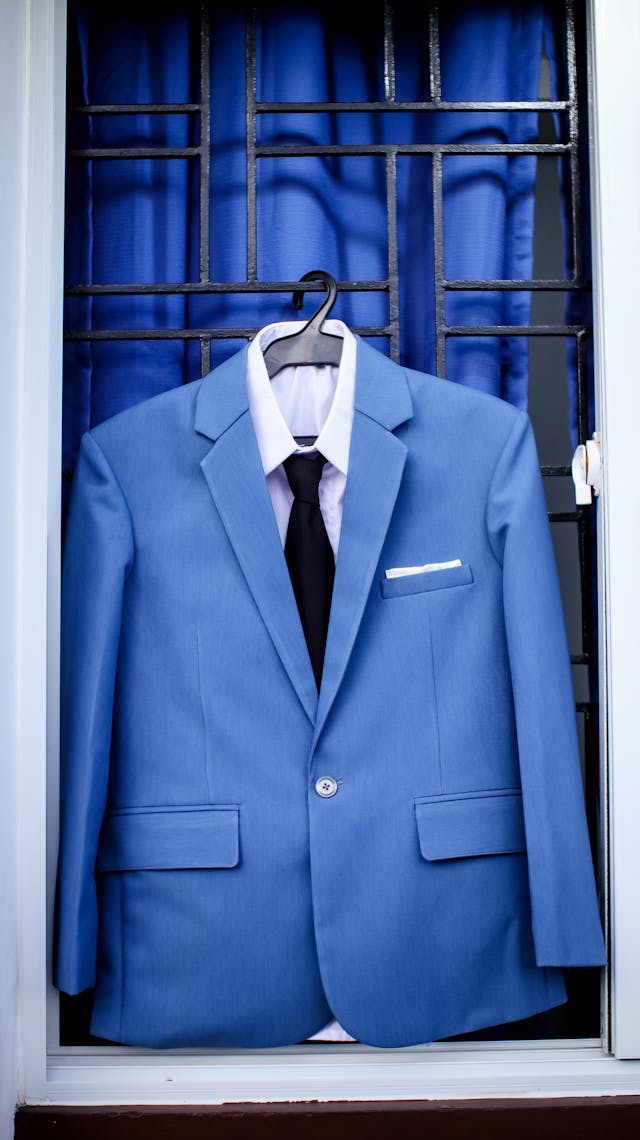

['suit', 'blue', 'men', 'elegant']


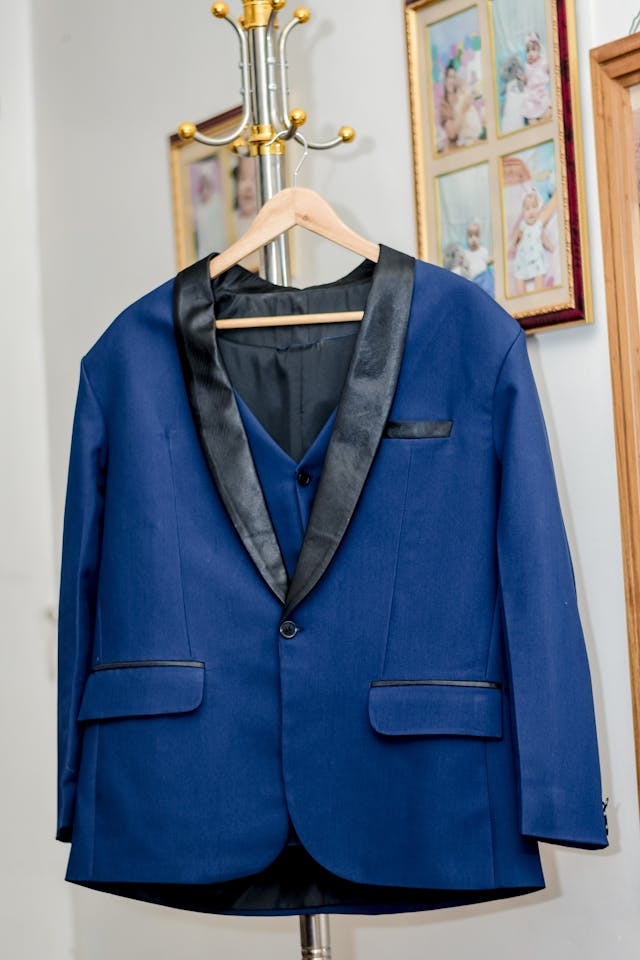

['suit', 'blue', 'black', 'elegant', 'men']


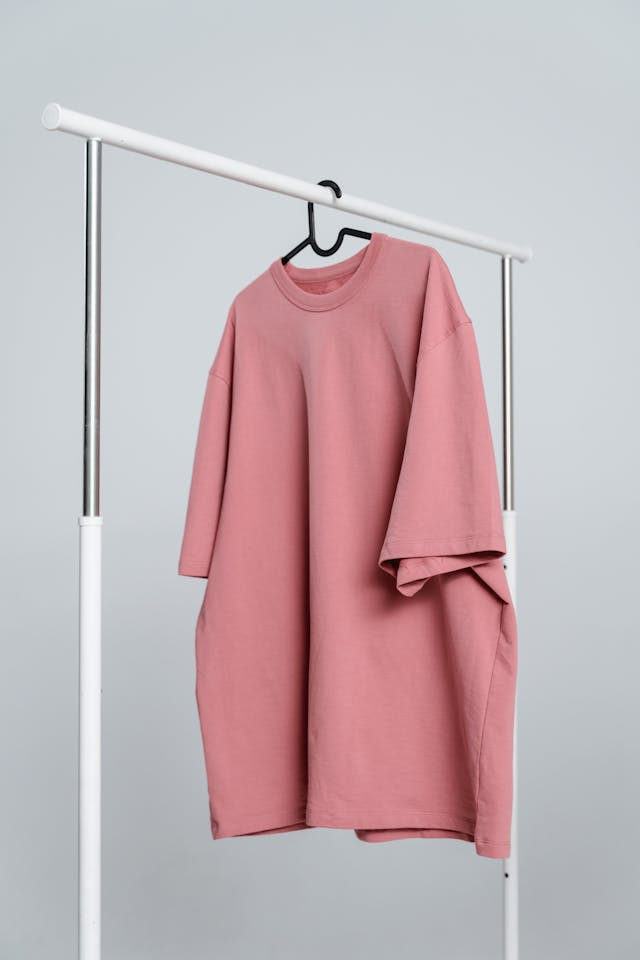

['T-shirt', 'cotton', 'casual', 'red']


In [12]:
for image_path in images[:4]:
  response_text = generate_keywords(image_path)
  display(Image(image_path))
  print(response_text)

### Keyword correction and deduplication

Unfortunately, despite providing a list of possible keywords, the model, at least in theory, can return an invalid keyword. It may be a duplicate e.g. "denim" for "jeans", or be completely unrelated to any keyword from the list.

To address these issues, you can use embeddings to map the keywords to predefined ones and remove unrelated ones.

In [13]:
def embed(text):
  embedding = genai.embed_content(model="models/embedding-001",
                                    content=text,
                                    task_type="semantic_similarity")
  return np.array(embedding["embedding"])

keywords_df = pd.DataFrame({'Keywords': keywords})
keywords_df["Embeddings"] = keywords_df['Keywords'].apply(embed)

In [14]:
keywords_df.head()

,Keywords,Embeddings
0,flannel,"[-0.010662252, -0.036850516, 0.041096944, -0.0..."
1,shorts,"[0.033239827, 0.00013335695, 0.031834923, -0.0..."
2,pants,"[0.012273628, -0.024099141, 0.0032160964, -0.0..."
3,dress,"[0.010586792, -0.023003917, -0.028866827, -0.0..."
4,T-shirt,"[-0.015854606, -0.05586348, 0.025282644, -0.04..."


For demonstration purposes, define a function that assesses the similarity between two embedding vectors. In this case, you will use cosine similarity, but other measures such as dot product work too.

In [15]:
def cosine_similarity(array_1, array_2):
  return np.dot(array_1,array_2)/(np.linalg.norm(array_1)*np.linalg.norm(array_2))

Next, define a function that allows you to replace a keyword with the most similar word in the keyword dataframe that you have previously created.

Note that the threshold is decided arbitrarily, it may require tweaking depending on use case and dataset.

In [16]:
def replace_word_with_most_similar(keyword, keywords_df, threshold=0.7):
  # No need for embeddings if the keyword is valid.
  if keyword in keywords_df["Keywords"]:
    return keyword
  embedding = embed(keyword)
  similarities = keywords_df['Embeddings'].apply(lambda row_embedding: cosine_similarity(embedding, row_embedding))
  most_similar_keyword_index = similarities.idxmax()
  if similarities[most_similar_keyword_index] < threshold:
    return None
  return keywords_df.loc[most_similar_keyword_index, "Keywords"]

Here is an example of how these keywords can be mapped to a keyword with the closest meaning.

In [17]:
for word in ["purple", "tank top", "everyday"]:
  print(word, "->", replace_word_with_most_similar(word, keywords_df))

purple -> violet
tank top -> T-shirt
everyday -> casual


You can now either leave words that do not fit our predefined categories or delete them. In this scenario, all words without a suitable replacement will be omitted.

In [18]:
def map_generated_keywords_to_predefined(generated_keywords, keywords_df=keywords_df):
  output_keywords = set()
  for keyword in generated_keywords:
    if mapped_keyword := replace_word_with_most_similar(keyword, keywords_df):
      output_keywords.add(mapped_keyword)
  return output_keywords

print(map_generated_keywords_to_predefined(["white", "business", "sport", "women", "polyester"]))
print(map_generated_keywords_to_predefined(["blue", "jeans", "women", "denim", "casual"]))

{'white', 'sport', 'women', 'polyester'}
{'blue', 'women', 'casual', 'denim'}


### Generating captions

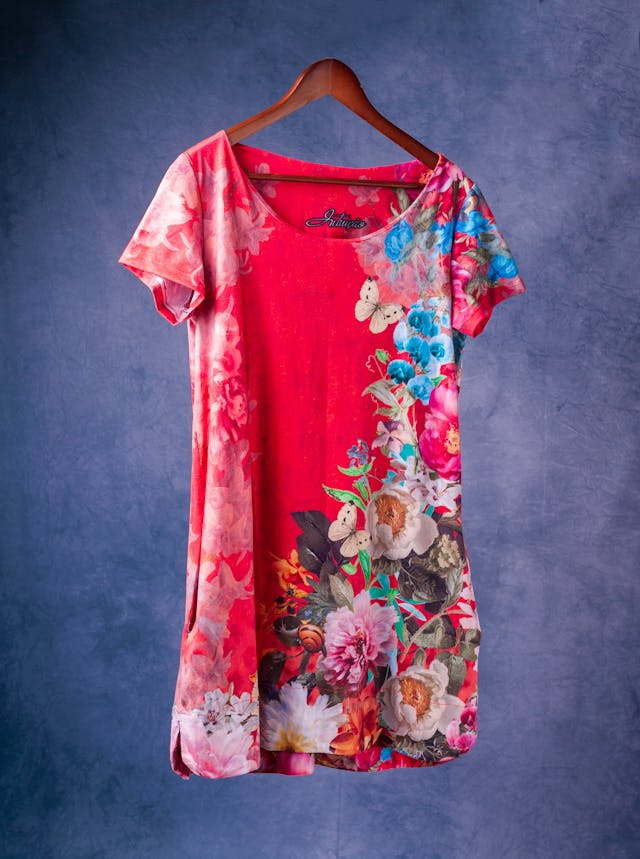

A red, floral print, short-sleeved, women's dress made of a silky material. 



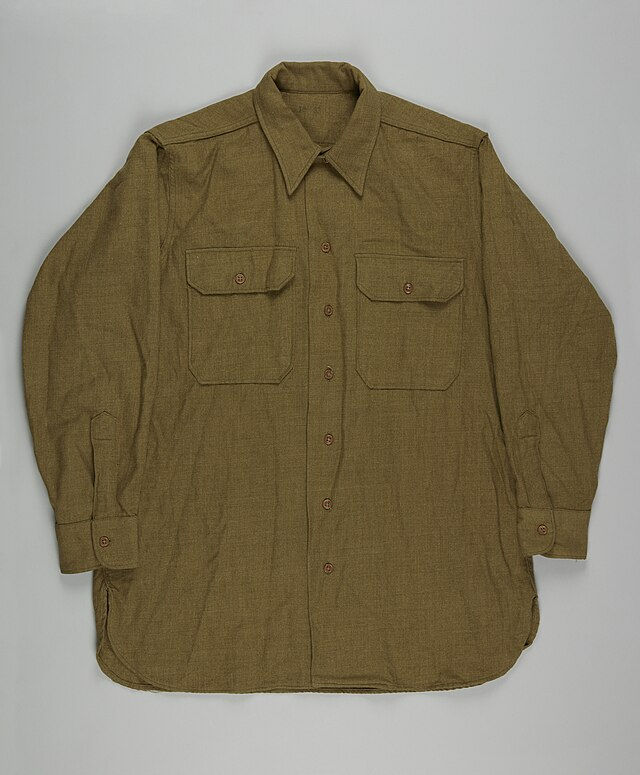

This is a men's brown long-sleeved flannel shirt. 



In [19]:
caption_prompt ="""
You are an expert in clothing that specializes in describing images of clothes, shoes and accessories.
Your job is to extract information from a photo that will help describe an item.
You are going to see an image, focus only on the piece of clothing, ignore suroundings.
Be specific, but stay concise, the description should only be one sentence long.
Most important aspects are color, type of clothing, material, style and who is it meant for.
If you are not sure about a part of the image, ignore it.
"""
def generate_caption(image_path):
  return generate_text_using_image(caption_prompt, image_path)

for image_path in images[8:]:
  response_text = generate_caption(image_path)
  display(Image(image_path))
  print(response_text)

## Searching for specific clothes

### Preparing out dataset
First, you need to generate caption and keywords for every image. Then, you will use embeddings, which will be used later to compare the images in the search dataset with other descriptions and images.

Also, the `ast.literal_eval()` helper function allows you to evaluate an object passed in and get the literal object. For instance, if you passed in a string `"[1, 2, 3]"`, the `ast.literal_eval()` function would return it as a list `[1, 2, 3]`. For more information on this function, here is the [documentation](https://docs.python.org/3/library/ast.html).

In [20]:
import ast

def generate_keyword_and_caption(image_path):
  keywords = generate_keywords(image_path)
  try:
    keywords = ast.literal_eval(keywords)
    keywords = map_generated_keywords_to_predefined(keywords)
  except SyntaxError:
    pass
  caption = generate_caption(image_path)
  return {
      "image_path": image_path,
      "keywords": keywords,
      "caption": caption
  }

You will use only the first 8 images, so the rest can be used for testing.

In [21]:
described_df = pd.DataFrame([generate_keyword_and_caption(image_path) for image_path in images[:8]])

In [22]:
def embed_row(row):
  text = ", ".join(row["keywords"]) + ".\n" + row["caption"]
  return embed(text)

In [23]:
described_df["embeddings"] = described_df.apply(lambda x: embed_row(x), axis=1)

In [24]:
described_df

,image_path,keywords,caption,embeddings
0,/content/clothes-dataset/9.jpg,"{shorts, blue, denim}",A pair of blue denim shorts for men with distr...,"[0.06048733, -0.00023415766, 0.052774053, -0.0..."
1,/content/clothes-dataset/8.jpg,"{men, blue, suit, elegant}","It is a blue, formal men's suit jacket made of...","[0.055953283, -0.0584283, -0.009110319, -0.048..."
2,/content/clothes-dataset/7.jpg,"{black, blue, suit, elegant, men}",It is a men's blue suit jacket with a black sa...,"[0.053380907, -0.06276393, -0.0081405835, -0.0..."
3,/content/clothes-dataset/6.jpg,"{red, T-shirt, casual, cotton}",A pink oversized cotton t-shirt for men. \n,"[0.06607768, -0.05598969, 0.00412737, -0.03128..."
4,/content/clothes-dataset/5.jpg,"{red, casual, silk, dress}","It is a maroon, flowing, short-sleeved, v-nec...","[0.051283136, -0.0445857, -0.009598117, -0.027..."
5,/content/clothes-dataset/4.jpg,"{black, orange, blue, green, casual, dress, wh...","A colorful, printed silk t-shirt dress with a ...","[0.04472915, -0.04071835, 0.012374706, -0.0470..."
6,/content/clothes-dataset/3.jpg,"{blue, casual, denim}",A pair of light blue denim jeans for men. \n,"[0.050465696, -0.014592526, 0.023665218, -0.06..."
7,/content/clothes-dataset/2.jpg,"{black, shirt, white, flannel}",It is a black and brown plaid flannel shirt fo...,"[-0.013179216, -0.047944095, 0.026174754, -0.0..."


### Finding clothes using natural language

In [25]:
def find_image_from_text(text):
  text_embedding = embed(text)
  similarities = described_df['embeddings'].apply(lambda row_embedding: cosine_similarity(text_embedding, row_embedding))
  most_fitting_image_index = similarities.idxmax()
  return described_df["image_path"][most_fitting_image_index]

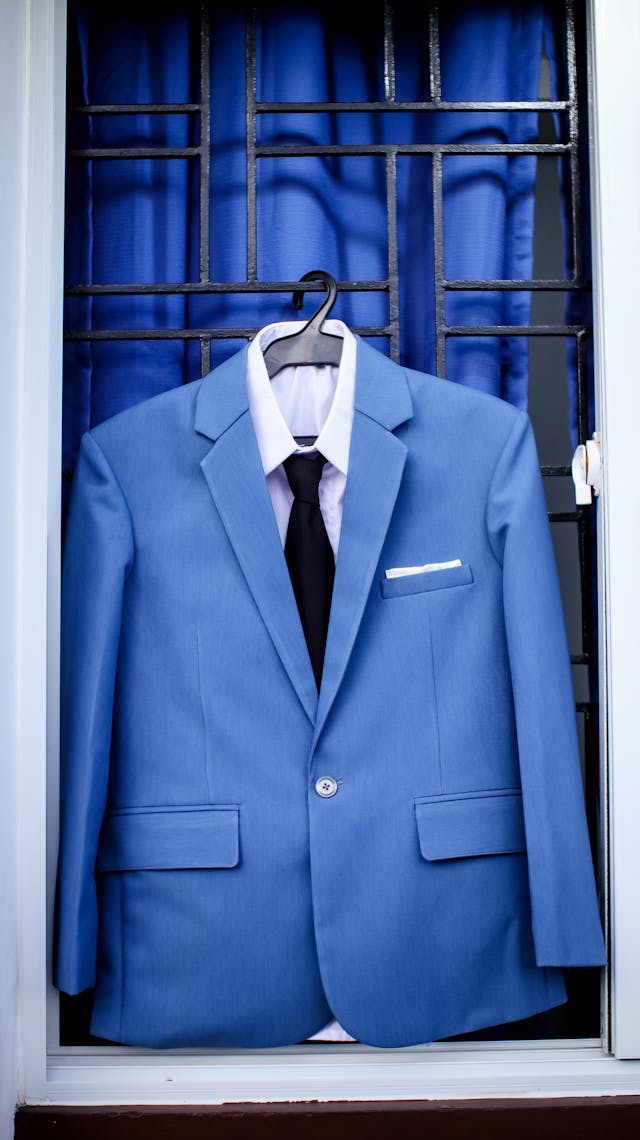

In [26]:
display(Image(find_image_from_text("A suit for a wedding.")))

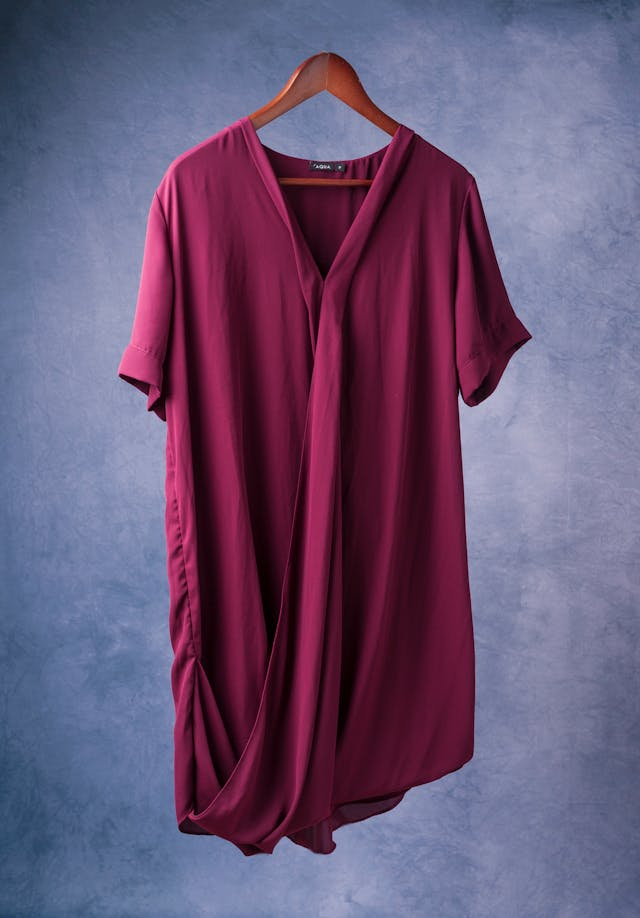

In [27]:
display(Image(find_image_from_text("A colorful dress.")))

### Finding similar clothes using images

In [28]:
def find_image_from_image(image_path):
  text_embedding = embed_row(generate_keyword_and_caption(image_path))
  similarities = described_df['embeddings'].apply(lambda row_embedding: cosine_similarity(text_embedding, row_embedding))
  most_fitting_image_index = similarities.idxmax()
  return described_df["image_path"][most_fitting_image_index]

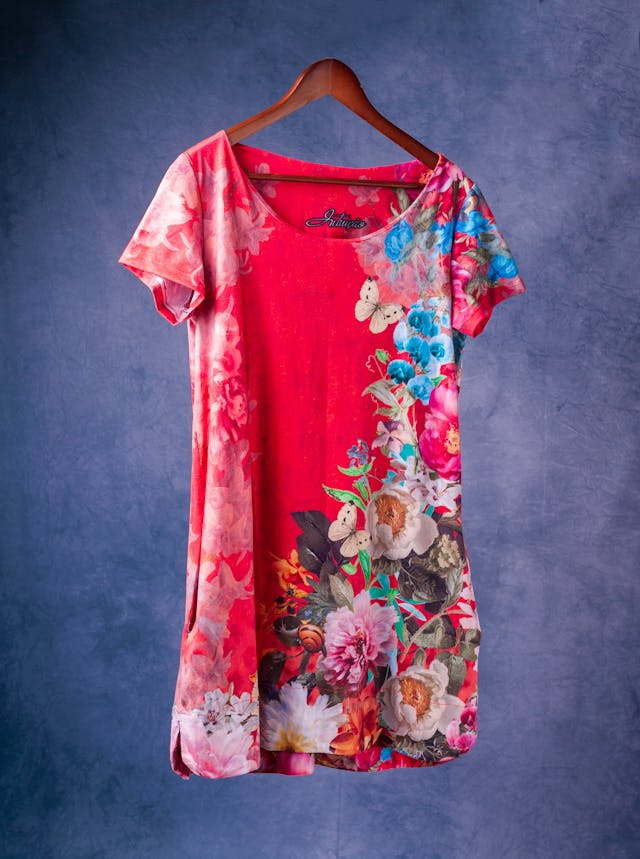

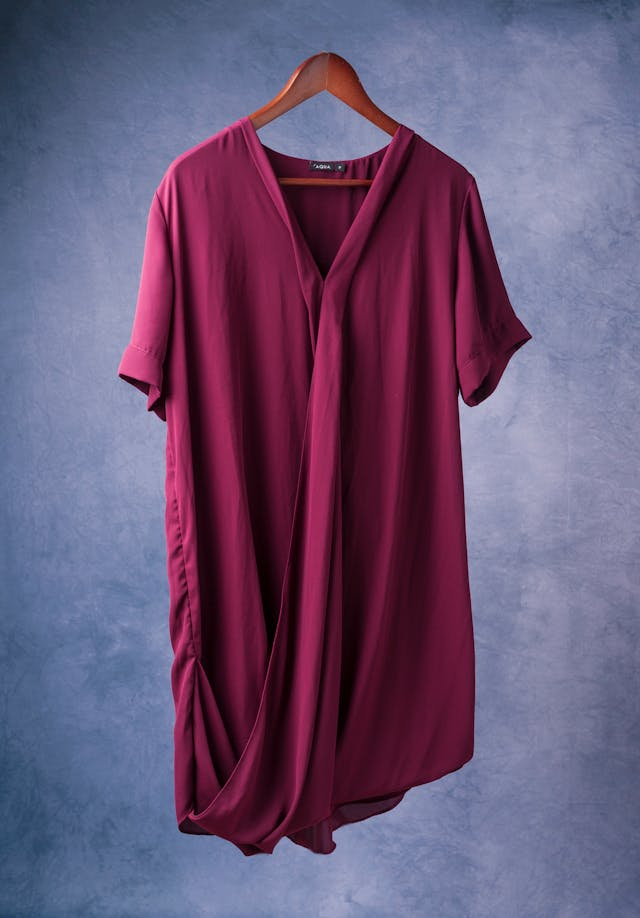

In [29]:
image_path = images[8]
display(Image(image_path))
display(Image(find_image_from_image(image_path)))

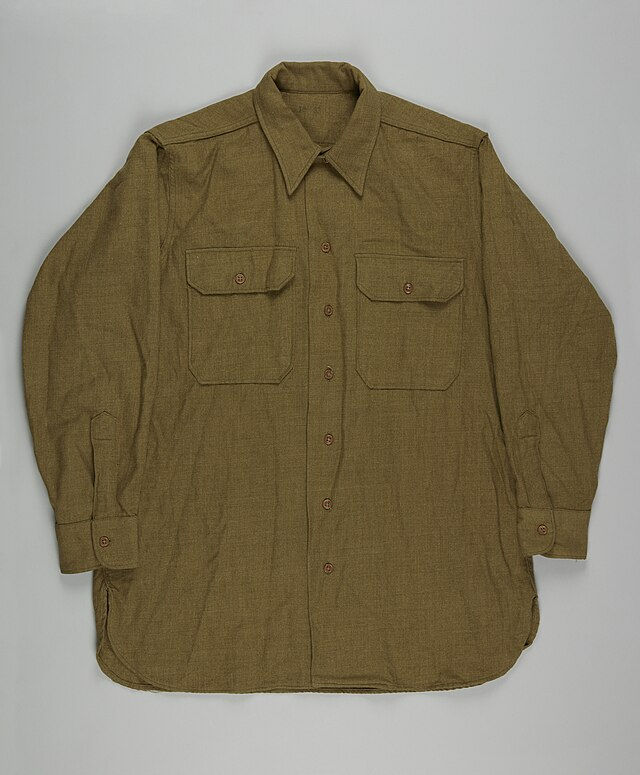

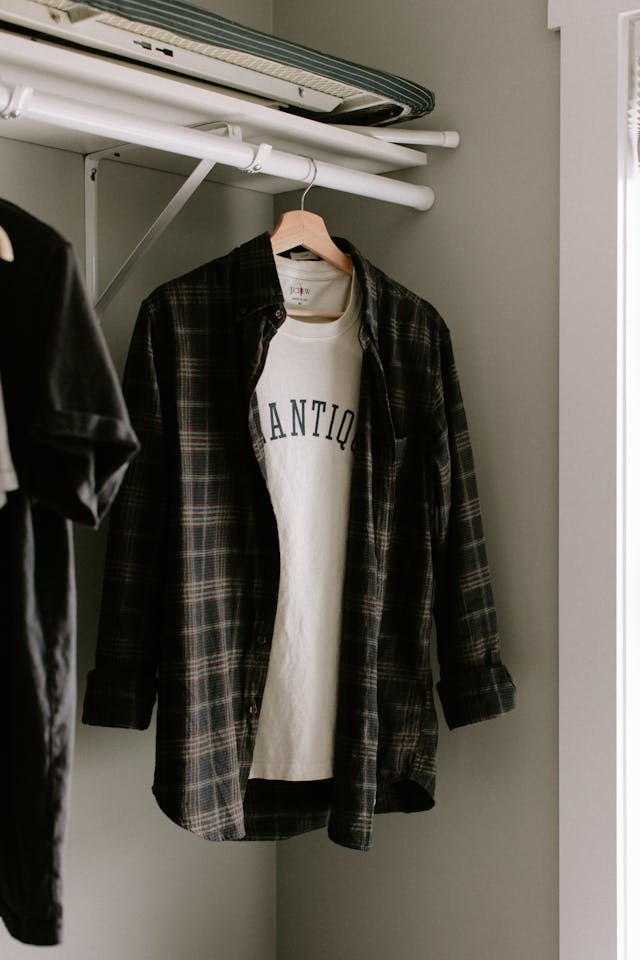

In [30]:
image_path = images[9]
display(Image(image_path))
display(Image(find_image_from_image(image_path)))

# Summary
You have used Gemini API's Python SDK to tag and caption images of clothing. Using embedding models, you were able to search a database of images for clothing matching our description, or similar to the provided clothing item.